# Adapted by: Dr. Isam Al Jawarneh

Date: 4 March 2024


##Target
analyzing fine-grained (i.e., granular) environmental data. In this notebook :

- time series graphs
- basic maps with environmental data (low-cost Air Quality, AQ, sensors data)
- Perform clustering analysis (e.g., DBSCAN) on pollution hotspots


##Part 0: Setup


Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.


In [1]:
#Block 1
#here, we install the tool we are going to use to make some maps, called Folium
%%capture
!pip install folium
!pip install osmnx

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [33]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os
import osmnx as ox

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Point

## Part 1 -Time Series


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future!


In [7]:
%ls "/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData"

nyc1.csv  NYC_Pilot1_PM.csv  nyc_polygon.geojson


In [8]:
#Block 3

#below are the files for temp/humidity, PM and NO2 data.
#data from other deployments, including your own, may have only one file. If this is the case, use only one variable!

#th = "NYC_Pilot1.csv"
pm = "/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData/NYC_Pilot1_PM.csv"

#no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
#thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
#no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.


In [9]:
pmdata.shape[0]

118765

In [10]:
#Block 4
tz = pytz.timezone('US/Eastern')
print("Data read")

Data read


In [11]:
#Block 5

#here, we will show the first few lines of the data files. Check out what the start date and times are!
#thdata.head()

#uncomment the line below to see the start of the PM data file!
pmdata.head()

#uncomment the line below to see the start of the NO2 data file!
#no2data.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10
0,NYCP1_01A,1579618560,40.847183,-73.870087,23,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.3,15.2,1.44,5.91,11.35
1,NYCP1_01A,1579618560,40.847183,-73.870094,18,2,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.2,15.1,1.05,1.18,1.18
2,NYCP1_01A,1579618560,40.847179,-73.870094,18,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.1,15.1,0.74,0.76,0.76
3,NYCP1_01A,1579618560,40.847179,-73.870094,18,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.1,15.2,1.15,4.48,47.36
4,NYCP1_01A,1579618560,40.847179,-73.870094,20,3,0,2,2,0,...,0.0,0.0,0.0,0.0,0.0,16.0,15.2,2.13,5.77,6.18


In [12]:
#Block 6
#here, we will show the last few lines of the data files. Check out what the ending date and times are!
#thdata.tail()

#uncomment the line below to see the end of the PM data file!
pmdata.tail()

#uncomment the line below to see the end of the NO2 data file!
#no2data.tail()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10
118760,NYCP1_01A,1581033300,40.819511,-73.898369,40,6,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,14.0,86.0,3.91,4.03,4.03
118761,NYCP1_01A,1581033300,40.819511,-73.898369,48,2,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,14.0,86.1,4.87,6.15,6.20
118762,NYCP1_01A,1581033300,40.819511,-73.898369,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,14.1,86.0,0.00,0.00,0.00
118763,NYCP1_01A,1581033300,40.819511,-73.898369,37,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,13.9,86.4,2.45,2.49,2.49
118764,NYCP1_01A,1581033300,40.819511,-73.898369,39,2,2,0,2,0,...,0.0,0.0,0.0,0.0,0.0,13.9,86.3,4.63,9.82,10.49


Time to warm up with a map. Let's find some parameters from the deployment in time series - let's start with temperature and then try PM2.5!

Let's get some basic information about temperature from this deployment -

- The average temperature the devices saw
- The maximum temperatures the devices saw
- The minimum temperature the devices saw


Avg value 8.244882751652423 Max value 10471.0 Min value -7.9
max pm10:  87341.71


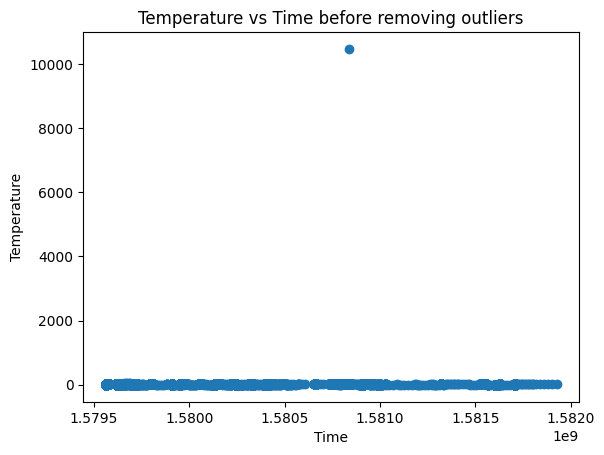

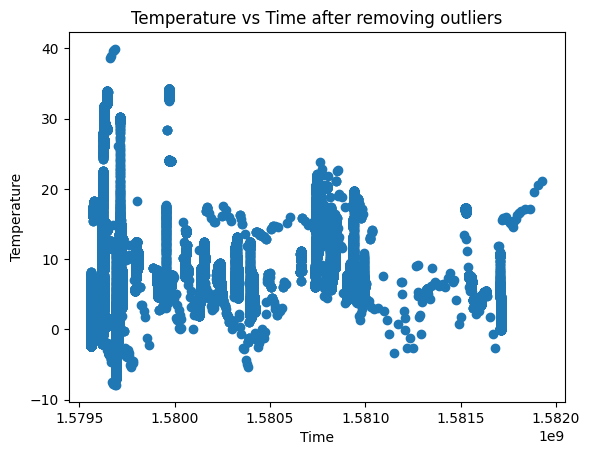

In [13]:
#Block 7
avg = pmdata['temperature'].mean()
max = pmdata['temperature'].max()
min = pmdata ['temperature'].min()


#now that we have those values, let's print them out so we can take a look
print("Avg value",avg, "Max value",max, "Min value",min)
maxpm10= pmdata['pm10'].max()
print('max pm10: ',maxpm10)

# scatter plot before removing the outlier
plt.scatter(pmdata['time'],pmdata['temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time before removing outliers')
plt.show()

# removing the outlier which is the only one value (10471.0)
pmdata = pmdata[pmdata['temperature'] != max]

# scatter plot after removing the outlier
plt.scatter(pmdata['time'],pmdata['temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time after removing outliers')
plt.show()


#th file variable names
#temperature, humidity

#pm file variable names
#pm25

#no2 file variable names
#no2

Now let's make a plot of the total temperature during the time we have collected the data for.


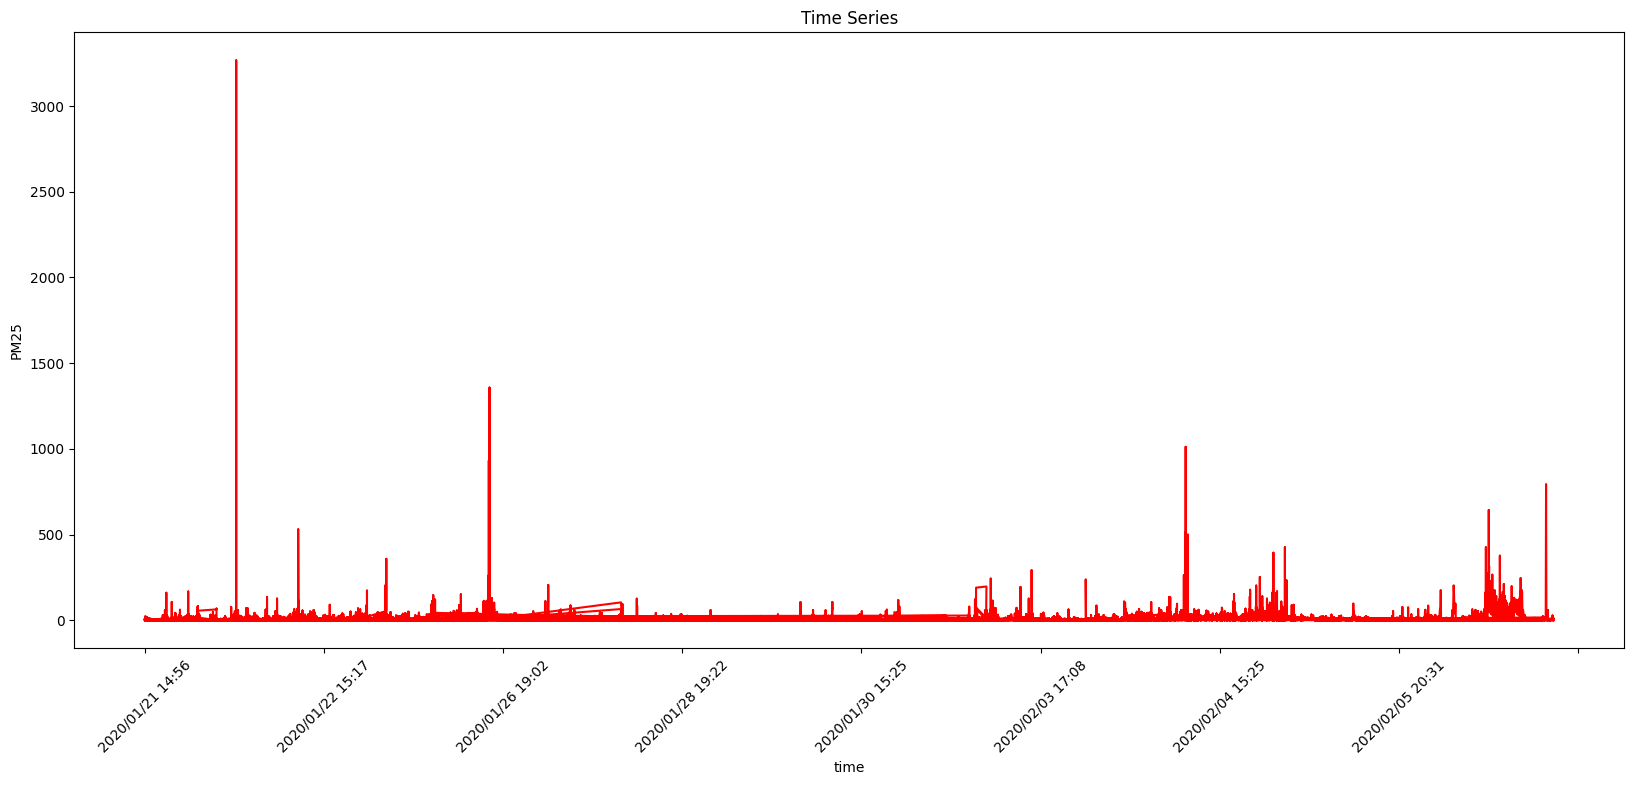

In [14]:
#Block 8

#Since our time data is in a Unix timestamp format, we need to convert it to a more readable format.


# Assuming pmdata is your DataFrame
pmdata['time'] = pd.to_datetime(pmdata['time'], unit='s')  # Assuming the time is in seconds
# Now, format the datetime as desired
pmdata['time'] = pmdata['time'].dt.strftime('%Y/%m/%d %H:%M')

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(pmdata["time"], pmdata["pm25"], 'r')
ax.set(xlabel="time",
       ylabel="PM25",
       title="Time Series")
tick_spacing = 500
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show()


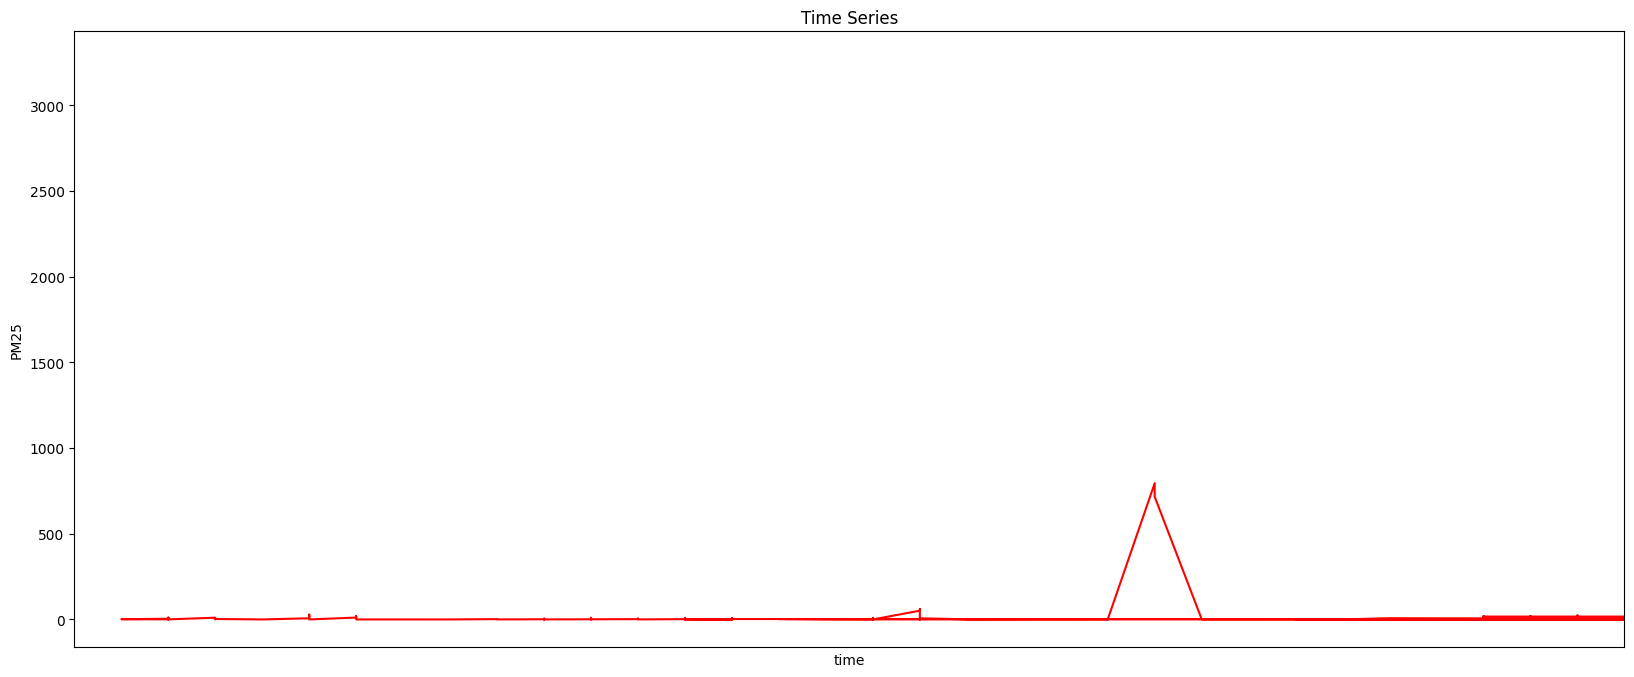

In [15]:
#Block 9
#this is a helpful image, but what if we just want to know the time series for one week, or another period of time?
#we can select the time we want to create a time series for using the code below.

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(pmdata["time"], pmdata["pm25"], 'r')

ax.set(xlabel="time",
       ylabel="PM25",
       title="Time Series",
       xlim=["2020/01/01 23:11", "2020/02/17 08:10"]
       ) #set the time range you are interested in using in the square brackets!
tick_spacing = 500                                                     #play with this number to increase or decrease the number of x axis labels
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show()



#you can modify the pm and no2 files using a similar structure as above!

Great - now replace the temperature parameters with humidity, and even pm2.5 or no2 from the other data files. Rerun the code and see what you get! What does the data tell you?


## Part 2 - Mapping + Hotspot Analysis


Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map!


In [16]:
pmdata.shape[0]

118764

In [17]:
pmdata_sample = pmdata.sample(frac=0.1)

In [18]:
pmdata_sample.shape[0]

11876

In [19]:
pmdata_sample.dtypes

SensorID        object
time            object
latitude       float64
longitude      float64
bin0             int64
bin1             int64
bin2             int64
bin3             int64
bin4             int64
bin5             int64
bin6             int64
bin7             int64
bin8             int64
bin9             int64
bin10            int64
bin11            int64
bin12          float64
bin13          float64
bin14          float64
bin15          float64
bin16          float64
bin17          float64
bin18          float64
bin19          float64
bin20          float64
bin21          float64
bin22          float64
bin23          float64
temperature    float64
humidity       float64
pm1            float64
pm25           float64
pm10           float64
dtype: object

In [20]:
#Block 10
#we're going to make a map. we start by setting a center point for the map to display the data
coords = pmdata.loc[:,['latitude','longitude']].values #lat and lon are collected from CityScanner GPS
start_point=coords[0]

In [21]:
pmdata_sample.iloc[5]['pm25']

30.26

In [22]:
# for i,row in pmdata_sample.iterrows():
#   print(pmdata_sample.loc[i]["pm25"])

In [23]:
#Block 11
#here, we set up the specifications for the map
newmap = folium.Map(location= start_point, tiles='Stamen Terrain', zoom_start=14)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=21)
colormap.caption = 'PM 2.5 (ug/m^3)' #change this to represent the variable of interest!
colormap.add_to(newmap)


#this will loop through the data and show us where it's coming from
#each point on the map will display the PM2.5 value from that spot, in micrograms per cubic meter.
for i,row in pmdata_sample.iterrows():
    #folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['pm25']), fill ='true', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)

newmap.add_child(colormap)
#here we save an html version of the map - you can zoom in and out of it and interact with it!
#this .html file will be saved to your google drive folder. Download it to your computer and open it to interact with it!
newmap.save('newmap.html')
#you may need to refresh the page on your google drive folder to see the updated map!
#you may also need to close a few tabs so you don't run out of memory when opening the map :)


#note - you can also create a map for a subset of the total deployment time by calling the "thdatamod", "pmdatamod", or "no2datamod" variable above!

Now that we have our point map, showing us where pm2.5 values and potential hotspot locations are, let's do some clustering. This will allow us to see where multiple measurements exceed the threshold value, potentially indicating a local source of pollution or pollution transport.


In [24]:
newmap

Output hidden; open in https://colab.research.google.com to view.

In [25]:
#Block 12
#let's start by setting 10 as the threshold value. Change this and see how the number of hotspots changes!
pmdata = pmdata.loc[(pmdata['pm25'] > 10)]

In [26]:
pmdata.shape[0]

21612

In [27]:
#Block 13
#hierarchical clustering code

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
outliers = coords[cluster_labels == -1]

#here is where we create the clusters after doing the background math above
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
outliers = coords[cluster_labels == -1]
print('Number of clusters: {}'.format(num_clusters))



Number of clusters: 41


# Part 3 - Extract Street Network and Perform Spatial Analysis

---


Now we need to extract the street network of NYC using the boundaries in the nyc_polygon.geojson file which will ensure that the analysis is confined to the area of interest only.


In [28]:
#loading the nyc_polygon.geojson file
nyc_polygon = gpd.read_file('/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData/nyc_polygon.geojson')

# making sure that the CRS is correct (coordinate reference system)
nyc_polygon = nyc_polygon.to_crs('EPSG:4326')

#extracting the street network for walking
G = ox.graph_from_polygon(nyc_polygon.geometry.unary_union, network_type='walk')
#this code took 12m 38s to run :) becareful

# part 4 - Performing spatial join


We need to convert the air quality data to a Geodataframe and do a spatial join with the street network. This step will link each air quality measurement with the nearest street segment


In [29]:
gdf_pm = gpd.GeoDataFrame(
    pmdata, geometry=gpd.points_from_xy(pmdata.longitude, pmdata.latitude),
    crs='EPSG:4326'
)


#converting to Geodataframe
nodes, edges = ox.graph_to_gdfs(G)

# the spatial join (linking each air quality measurement with the nearest street segment)
joined_data = gpd.sjoin_nearest(gdf_pm, edges, how="left")


/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting a warning here:
UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

warnings.warn


this warning is probably because we are using sjoin_nearest which involves calculating distances between air quality measurements and street segments and when geometries are in CRS 4326 distances are calculated on a sphere which can lead to innacuracies for certain spatial operations, especially for large distances.


# Part 5 - Route optimization (Approach 1)


In route optimization we will focus on calculating and visualizing the optimal route that minimizes pollution exposure.

In [48]:
print(joined_data.columns)

Index(['SensorID', 'time', 'latitude', 'longitude', 'bin0', 'bin1', 'bin2',
       'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9', 'bin10',
       'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16', 'bin17', 'bin18',
       'bin19', 'bin20', 'bin21', 'bin22', 'bin23', 'temperature', 'humidity',
       'pm1', 'pm25', 'pm10', 'geometry', 'index_right0', 'index_right1',
       'index_right2', 'osmid', 'highway', 'oneway', 'reversed', 'length',
       'name', 'maxspeed', 'lanes', 'access', 'ref', 'service', 'tunnel',
       'width', 'bridge', 'junction', 'est_width', 'area'],
      dtype='object')


In [44]:
avg_pm25 = joined_data.groupby('index_right0')['pm25'].mean()

# Update the graph G with PM2.5 levels as weights
for u, v, key, data in G.edges(keys=True, data=True):
    # This assumes 'osmid' corresponds to 'index_right0' in joined_data
    # You might need to adjust this if a different identifier links edges in G to rows in joined_data
    if (u, v, key) in avg_pm25:
        G[u][v][key]['pm25_weight'] = avg_pm25.loc[(u, v, key)]
    else:
        G[u][v][key]['pm25_weight'] = float('inf')

In [46]:
import osmnx as ox

# Example: Central Park to Times Square
start_point = (40.785091, -73.968285)  # Central Park approximate location
end_point = (40.758896, -73.985130)  # Times Square approximate location

# Convert these points to the nearest nodes on the graph
# Updated method to find the nearest node
start_node = ox.distance.nearest_nodes(G, X=start_point[1], Y=start_point[0])
end_node = ox.distance.nearest_nodes(G, X=end_point[1], Y=end_point[0])

# Calculate the shortest path using the pollution weights
import networkx as nx
shortest_path = nx.shortest_path(G, start_node, end_node, weight='pm25_weight', method='dijkstra')

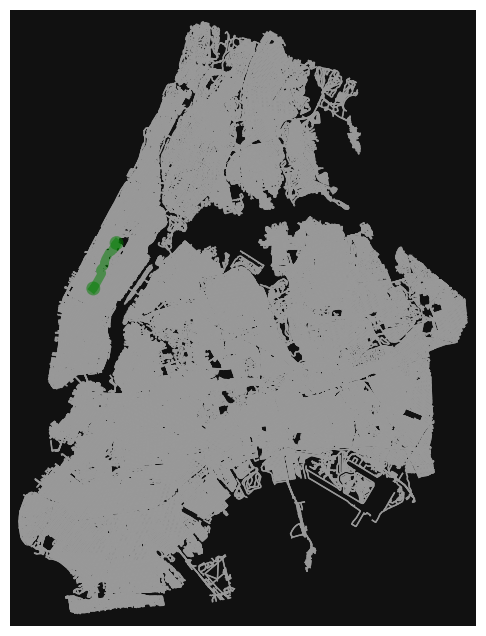

In [47]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(G, shortest_path, route_color='green', route_linewidth=6, node_size=0)

# Part 5 -Route optimization (Approach 2)

This process involves using the sjoin_nearest method from GeoPandas to spatially join air quality data points with the nearest street segments

In [49]:
# Ensure both GeoDataFrames are in the same projected CRS for accurate distance calculation
# It's recommended to use a local metric system for New York, such as EPSG:2263 (NAD83 / New York Long Island)
gdf_pm = gdf_pm.to_crs(epsg=2263)
edges = edges.to_crs(epsg=2263)

# Perform the spatial join to find the nearest street segment for each AQ data point
joined_data = gpd.sjoin_nearest(gdf_pm, edges, how="left", distance_col="nearest_distance")

This operation will append information from the nearest street segment to each row in air quality GeoDataFrame (gdf_pm), including a new column (nearest_distance) indicating the distance to the nearest street segment.

After associating each AQ point with a street segment, the next step is to aggregate the pollution data (e.g., PM2.5 levels) to assign weights to the street segments in the network graph (G). This involves calculating an average PM2.5 level for each street segment based on the associated AQ points.

In [53]:
joined_data['osmid'] = joined_data['osmid'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Now, every row in 'osmid' should have a single, hashable value, allowing you to group by 'osmid'
print(joined_data['osmid'].head())

# Proceed with calculating the average PM2.5 levels for each street segment
segment_pm25 = joined_data.groupby('osmid')['pm25'].mean()

# Confirming the operation works without errors
print(segment_pm25.head())

65      768012746
187     400335009
1427    771908429
1429    771908429
1431    771908429
Name: osmid, dtype: int64
osmid
5695603    15.500000
5695615    32.780000
5695912    68.740000
5696037    14.884737
5696089    14.796667
Name: pm25, dtype: float64


In [54]:
# Aggregate PM2.5 levels for each street segment
segment_pm25 = joined_data.groupby('osmid')['pm25'].mean()

# Update the graph with PM2.5 weights
for u, v, key, data in G.edges(keys=True, data=True):
    pm25_weight = segment_pm25.get(data['osmid'], None)
    if pm25_weight is not None:
        G[u][v][key]['pm25_weight'] = pm25_weight
    else:
        G[u][v][key]['pm25_weight'] = float('inf')

Now, to calculate the shortest path minimizing PM2.5 exposure and compare the Bellman-Ford and Dijkstra algorithms:

In [56]:
import networkx as nx

# Assuming start_node and end_node have been defined as nearest nodes to your points of interest
# Bellman-Ford
path_bellman_ford = nx.shortest_path(G, source=start_node, target=end_node, weight='pm25_weight', method='bellman-ford')

# Dijkstra
path_dijkstra = nx.shortest_path(G, source=start_node, target=end_node, weight='pm25_weight', method='dijkstra')

# You may calculate the total distance (km) for both paths to compare
def calculate_path_length(G, path):
    return sum(ox.utils_graph.get_route_edge_attributes(G, path, 'length'))

length_bellman_ford = calculate_path_length(G, path_bellman_ford)
length_dijkstra = calculate_path_length(G, path_dijkstra)

print(f"Total length via Bellman-Ford: {length_bellman_ford} meters")
print(f"Total length via Dijkstra: {length_dijkstra} meters")

NetworkXNoPath: Target 10228962359 cannot be reached from given sources

# part 6 - Advanced analysis (linear weighting method)


# Part 7 - Implementing an interactive map


##Summary
Now that you have finished going through this notebook, you should be able to create time series graphs, basic maps, and perform clustering analysis techniques on hyperlocal environmental data. Additionally, you should have a basic knowledge of some of the different pollutants that can be measured to tell us more about the quality of our immediate environment.


##Resources and references
Below you can find links to some of the CityScanner papers, some of the reference materials shown in the presentation, and some reference documentation for some of the python libraries!


CityScanner Papers:

- [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
- [ City Scanner: Building and Scheduling a Mobile
  Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
- [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)

Python Library Documentation:

- [Folium](http://python-visualization.github.io/folium/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
